Using device: cuda
Initializing models...

Training VAE with improved hyperparameters...
VAE Epoch 1/12, Batch 0, Loss: 72876.38, Recon: 71797.27, KL: 2158.21
VAE Epoch 1/12, Batch 300, Loss: 17163.82, Recon: 15449.79, KL: 3428.05
VAE Epoch 1/12 - Avg Loss: 159.0387, Recon: 147.1137, KL: 23.8500
VAE Epoch 2/12, Batch 0, Loss: 15770.19, Recon: 13859.91, KL: 3820.58
VAE Epoch 2/12, Batch 300, Loss: 14990.30, Recon: 12963.01, KL: 4054.58
VAE Epoch 2/12 - Avg Loss: 117.9142, Recon: 102.4330, KL: 30.9624
VAE Epoch 3/12, Batch 0, Loss: 13750.94, Recon: 11733.72, KL: 4034.44
VAE Epoch 3/12, Batch 300, Loss: 13308.53, Recon: 11300.08, KL: 4016.92
VAE Epoch 3/12 - Avg Loss: 105.7068, Recon: 90.1005, KL: 31.2126
VAE Epoch 4/12, Batch 0, Loss: 12448.69, Recon: 10456.83, KL: 3983.72
VAE Epoch 4/12, Batch 300, Loss: 12470.70, Recon: 10474.01, KL: 3993.38
VAE Epoch 4/12 - Avg Loss: 99.6615, Recon: 84.0072, KL: 31.3087
VAE Epoch 5/12, Batch 0, Loss: 12174.80, Recon: 10169.24, KL: 4011.12
VAE Epoch 5/

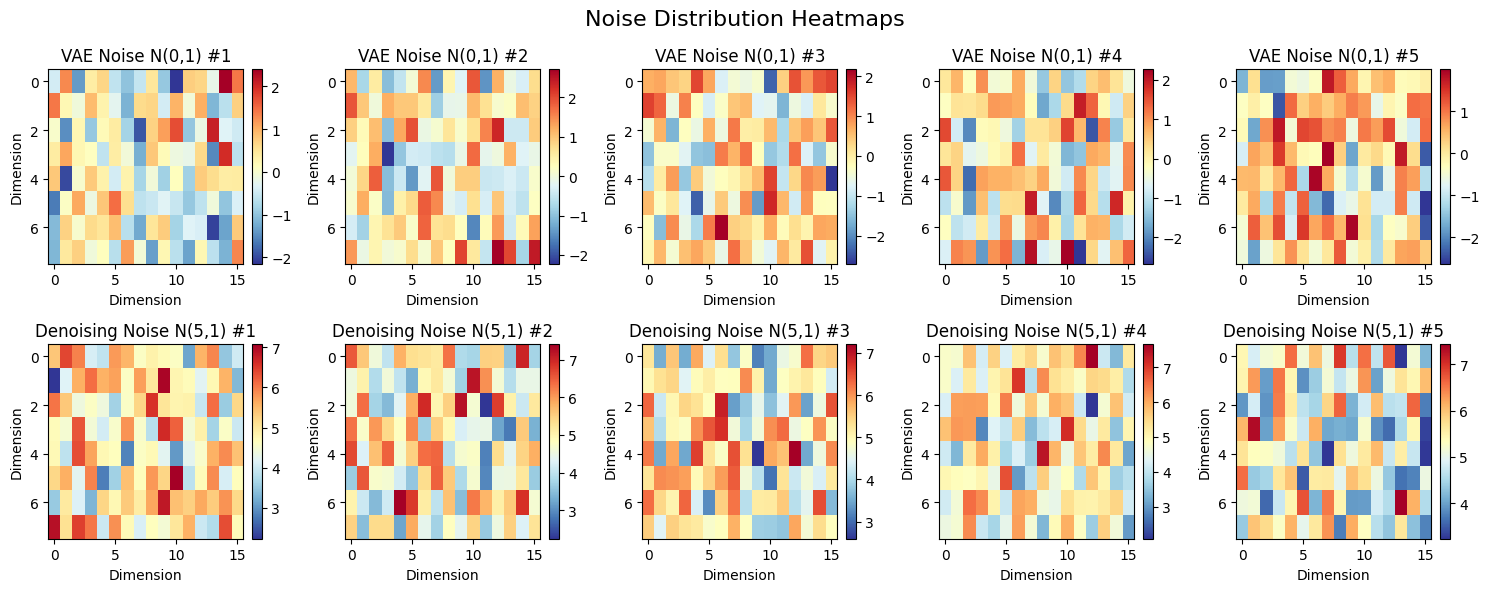

2. Comparing generated outputs...


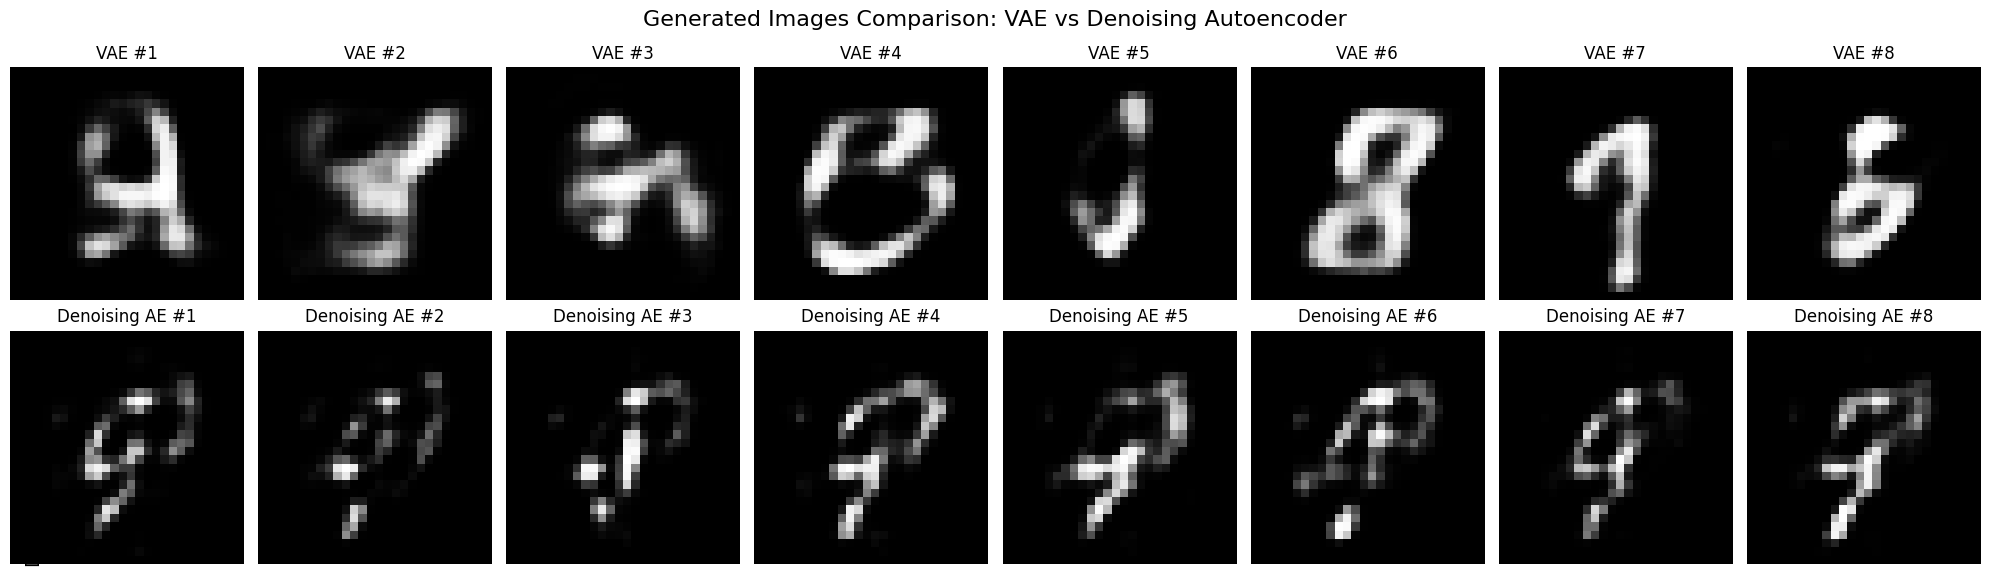

3. Computing t-SNE visualization of latent features...
Computing t-SNE for VAE features (sampled)...
Computing t-SNE for VAE features (mean only)...
Computing t-SNE for Denoising AE features...


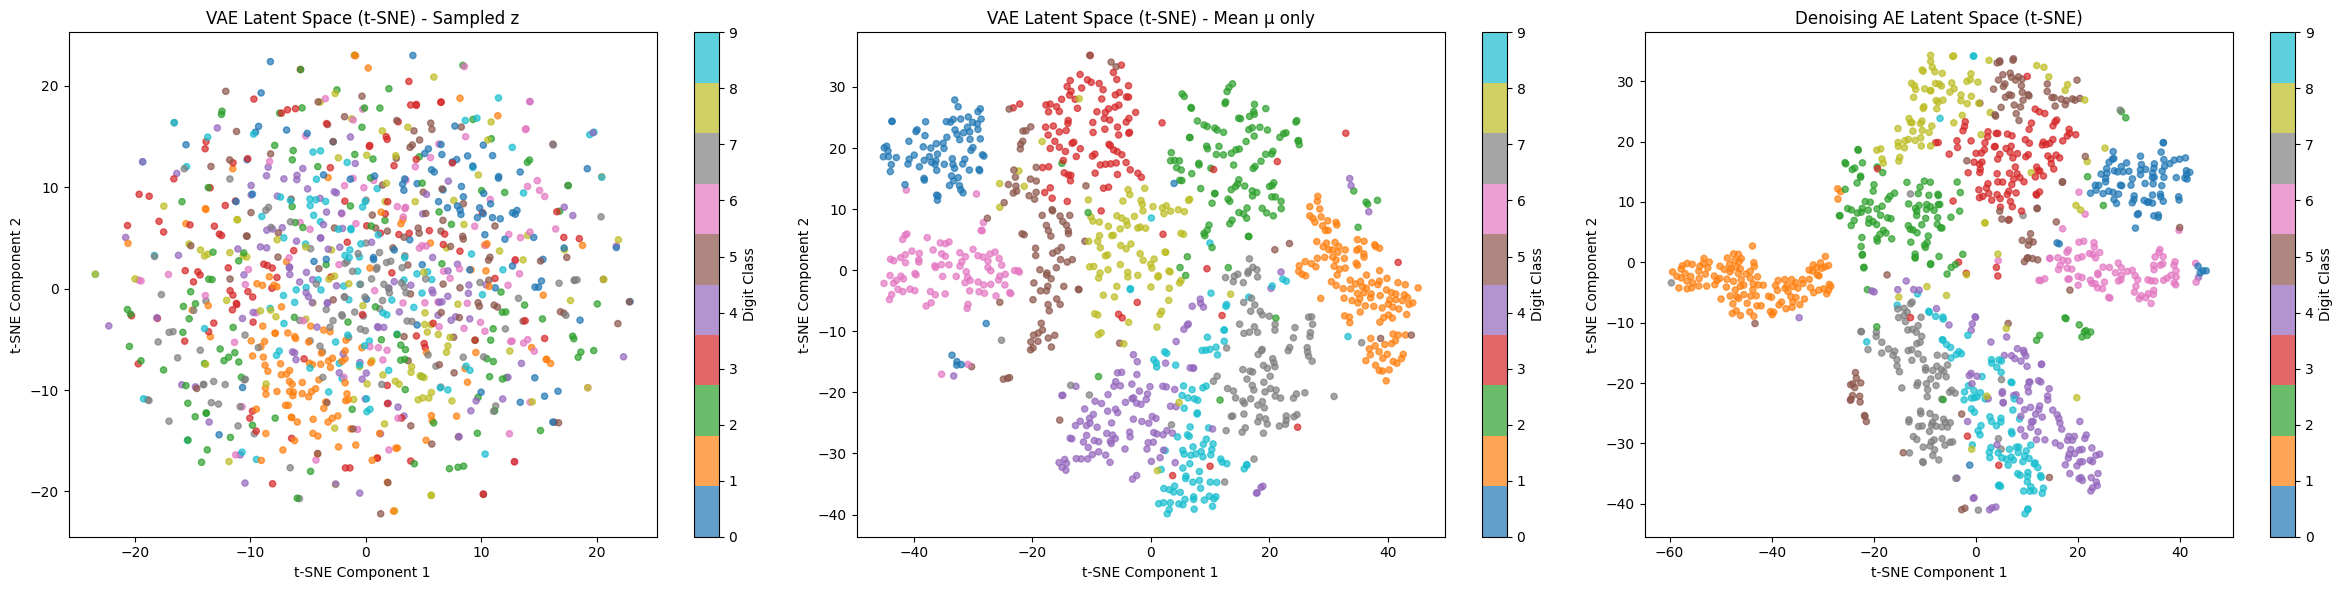


ANALYSIS SUMMARY
✓ Noise heatmaps show different distributions:
  - VAE uses N(0,1) - centered around 0
  - Denoising AE uses N(5,1) - centered around 5
✓ Generated images comparison shows:
  - VAE: More structured generation from learned prior
  - Denoising AE: Generation depends on noise distribution
✓ t-SNE visualization reveals:
  - VAE: Smooth, structured latent space
  - Denoising AE: Less structured latent representation


In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Variational Autoencoder Implementation
class VAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU()
        )
        
        # Latent space parameters
        self.fc_mu = nn.Linear(256, latent_dim)      # Mean
        self.fc_logvar = nn.Linear(256, latent_dim)  # Log variance
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        return mu, logvar
    
    def reparameterize(self, mu, logvar):
        """Reparameterization trick: sample from N(mu, var) using N(0,1)"""
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def decode(self, z):
        return self.decoder(z)
    
    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decode(z)
        return recon, mu, logvar
    
    def generate(self, num_samples=5):
        """Generate new samples by sampling from prior N(0,1)"""
        with torch.no_grad():
            z = torch.randn(num_samples, self.latent_dim).to(device)
            samples = self.decode(z)
            return samples, z

# Denoising Autoencoder Implementation
class DenoisingAE(nn.Module):
    def __init__(self, latent_dim=128):
        super(DenoisingAE, self).__init__()
        self.latent_dim = latent_dim
        
        # Encoder
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, latent_dim),
            nn.ReLU()
        )
        
        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded, encoded
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, z):
        return self.decoder(z)

# VAE Loss Function
def vae_loss(recon_x, x, mu, logvar, beta=1.0):
    """VAE loss = Reconstruction loss + KL divergence"""
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon_loss + beta * kl_loss, recon_loss, kl_loss

# Denoising AE Loss Function
def denoising_loss(recon_x, x):
    return F.mse_loss(recon_x, x, reduction='sum')

# Training function for VAE (improved)
def train_vae(model, train_loader, epochs=10, beta=0.5):  # Reduced beta
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)  # Reduced learning rate
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.8)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        total_recon = 0
        total_kl = 0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(data.size(0), -1).to(device)
            data = (data + 1) / 2  # Normalize to [0, 1]
            
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss, recon_loss, kl_loss = vae_loss(recon_batch, data, mu, logvar, beta)
            
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()
            total_recon += recon_loss.item()
            total_kl += kl_loss.item()
            
            if batch_idx % 300 == 0:
                print(f'VAE Epoch {epoch+1}/{epochs}, Batch {batch_idx}, '
                      f'Loss: {loss.item():.2f}, Recon: {recon_loss.item():.2f}, '
                      f'KL: {kl_loss.item():.2f}')
        
        scheduler.step()
        avg_loss = total_loss / len(train_loader.dataset)
        avg_recon = total_recon / len(train_loader.dataset)
        avg_kl = total_kl / len(train_loader.dataset)
        
        print(f'VAE Epoch {epoch+1}/{epochs} - Avg Loss: {avg_loss:.4f}, '
              f'Recon: {avg_recon:.4f}, KL: {avg_kl:.4f}')
        
        # Adaptive beta scheduling
        if epoch > 5 and avg_kl < 10:
            beta = min(1.0, beta * 1.1)  # Gradually increase beta

# Training function for Denoising AE
def train_denoising_ae(model, train_loader, epochs=10, noise_factor=0.3):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.8)
    
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        
        for batch_idx, (data, _) in enumerate(train_loader):
            data = data.view(data.size(0), -1).to(device)
            data = (data + 1) / 2  # Normalize to [0, 1]
            
            # Add noise to input
            noisy_data = data + noise_factor * torch.randn_like(data)
            noisy_data = torch.clamp(noisy_data, 0., 1.)
            
            optimizer.zero_grad()
            recon_batch, _ = model(noisy_data)
            loss = denoising_loss(recon_batch, data)
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            if batch_idx % 300 == 0:
                print(f'Denoising AE Epoch {epoch+1}/{epochs}, Batch {batch_idx}, Loss: {loss.item():.2f}')
        
        scheduler.step()
        print(f'Denoising AE Epoch {epoch+1}/{epochs} completed, Avg Loss: {total_loss/len(train_loader.dataset):.4f}')

# Noise Heatmap Visualization
def plot_noise_heatmaps(num_samples=5):
    """Plot heatmaps of different noise distributions"""
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    fig.suptitle('Noise Distribution Heatmaps', fontsize=16)
    
    for i in range(num_samples):
        # VAE noise: N(0,1)
        vae_noise = np.random.normal(0, 1, 128)
        vae_noise_2d = vae_noise.reshape(8, 16)  # Reshape to 2D for better visualization
        
        # Denoising AE noise: N(5,1)
        denoising_noise = np.random.normal(5, 1, 128)
        denoising_noise_2d = denoising_noise.reshape(8, 16)
        
        # Plot VAE noise
        im1 = axes[0, i].imshow(vae_noise_2d, cmap='RdYlBu_r', aspect='auto')
        axes[0, i].set_title(f'VAE Noise N(0,1) #{i+1}')
        axes[0, i].set_xlabel('Dimension')
        axes[0, i].set_ylabel('Dimension')
        plt.colorbar(im1, ax=axes[0, i], fraction=0.046, pad=0.04)
        
        # Plot Denoising AE noise
        im2 = axes[1, i].imshow(denoising_noise_2d, cmap='RdYlBu_r', aspect='auto')
        axes[1, i].set_title(f'Denoising Noise N(5,1) #{i+1}')
        axes[1, i].set_xlabel('Dimension')
        axes[1, i].set_ylabel('Dimension')
        plt.colorbar(im2, ax=axes[1, i], fraction=0.046, pad=0.04)
    
    plt.tight_layout()
    plt.show()

# Generate and compare outputs
def compare_outputs(vae_model, denoising_model, num_samples=8):
    """Compare generated outputs from both models"""
    
    # Generate VAE samples
    vae_samples, vae_z = vae_model.generate(num_samples)
    vae_samples = vae_samples.cpu().numpy().reshape(num_samples, 28, 28)
    
    # Generate Denoising AE samples using N(5,1) noise
    noise_vectors = torch.normal(mean=5, std=1, size=(num_samples, 128)).to(device)
    denoising_model.eval()
    with torch.no_grad():
        denoising_samples = denoising_model.decode(noise_vectors)
        denoising_samples = denoising_samples.cpu().numpy().reshape(num_samples, 28, 28)
    
    # Plot comparison
    fig, axes = plt.subplots(2, num_samples, figsize=(20, 6))
    fig.suptitle('Generated Images Comparison: VAE vs Denoising Autoencoder', fontsize=16)
    
    for i in range(num_samples):
        # VAE outputs
        axes[0, i].imshow(vae_samples[i], cmap='gray')
        axes[0, i].set_title(f'VAE #{i+1}')
        axes[0, i].axis('off')
        
        # Denoising AE outputs
        axes[1, i].imshow(denoising_samples[i], cmap='gray')
        axes[1, i].set_title(f'Denoising AE #{i+1}')
        axes[1, i].axis('off')
    
    # Add row labels
    fig.text(0.02, 0.75, 'VAE Generated', rotation=90, fontsize=14, ha='center', va='center')
    fig.text(0.02, 0.25, 'Denoising AE Generated', rotation=90, fontsize=14, ha='center', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return vae_samples, denoising_samples

# t-SNE Visualization of latent features
def plot_tsne_features(vae_model, denoising_model, test_loader, num_samples=1000):
    """Plot t-SNE visualization of latent features from both models"""
    
    # Collect latent features and labels
    vae_features = []
    vae_mu_features = []  # Just the mean, not reparameterized
    denoising_features = []
    labels = []
    
    vae_model.eval()
    denoising_model.eval()
    
    count = 0
    with torch.no_grad():
        for data, target in test_loader:
            if count >= num_samples:
                break
                
            data = data.view(data.size(0), -1).to(device)
            data = (data + 1) / 2  # Normalize to [0, 1]
            
            # Get VAE latent features
            mu, logvar = vae_model.encode(data)
            vae_z = vae_model.reparameterize(mu, logvar)  # Sampled version
            
            # Get Denoising AE latent features
            denoising_z = denoising_model.encode(data)
            
            # Store features and labels
            batch_size = min(data.size(0), num_samples - count)
            vae_features.append(vae_z[:batch_size].cpu().numpy())
            vae_mu_features.append(mu[:batch_size].cpu().numpy())  # Mean only
            denoising_features.append(denoising_z[:batch_size].cpu().numpy())
            labels.extend(target[:batch_size].numpy())
            
            count += batch_size
    
    # Concatenate all features
    vae_features = np.vstack(vae_features)
    vae_mu_features = np.vstack(vae_mu_features)
    denoising_features = np.vstack(denoising_features)
    labels = np.array(labels)
    
    # Apply PCA first to reduce dimensionality (for better t-SNE performance)
    pca = PCA(n_components=50)
    vae_features_pca = pca.fit_transform(vae_features)
    vae_mu_features_pca = pca.fit_transform(vae_mu_features)
    denoising_features_pca = pca.fit_transform(denoising_features)
    
    # Apply t-SNE
    print("Computing t-SNE for VAE features (sampled)...")
    tsne_vae = TSNE(n_components=2, random_state=42, perplexity=30)
    vae_tsne = tsne_vae.fit_transform(vae_features_pca)
    
    print("Computing t-SNE for VAE features (mean only)...")
    tsne_vae_mu = TSNE(n_components=2, random_state=42, perplexity=30)
    vae_mu_tsne = tsne_vae_mu.fit_transform(vae_mu_features_pca)
    
    print("Computing t-SNE for Denoising AE features...")
    tsne_denoising = TSNE(n_components=2, random_state=42, perplexity=30)
    denoising_tsne = tsne_denoising.fit_transform(denoising_features_pca)
    
    # Plot t-SNE results with 3 subplots
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 6))
    
    # VAE t-SNE (sampled)
    scatter1 = ax1.scatter(vae_tsne[:, 0], vae_tsne[:, 1], c=labels, cmap='tab10', s=20, alpha=0.7)
    ax1.set_title('VAE Latent Space (t-SNE) - Sampled z')
    ax1.set_xlabel('t-SNE Component 1')
    ax1.set_ylabel('t-SNE Component 2')
    plt.colorbar(scatter1, ax=ax1, label='Digit Class')
    
    # VAE t-SNE (mean only)
    scatter2 = ax2.scatter(vae_mu_tsne[:, 0], vae_mu_tsne[:, 1], c=labels, cmap='tab10', s=20, alpha=0.7)
    ax2.set_title('VAE Latent Space (t-SNE) - Mean μ only')
    ax2.set_xlabel('t-SNE Component 1')
    ax2.set_ylabel('t-SNE Component 2')
    plt.colorbar(scatter2, ax=ax2, label='Digit Class')
    
    # Denoising AE t-SNE
    scatter3 = ax3.scatter(denoising_tsne[:, 0], denoising_tsne[:, 1], c=labels, cmap='tab10', s=20, alpha=0.7)
    ax3.set_title('Denoising AE Latent Space (t-SNE)')
    ax3.set_xlabel('t-SNE Component 1')
    ax3.set_ylabel('t-SNE Component 2')
    plt.colorbar(scatter3, ax=ax3, label='Digit Class')
    
    plt.tight_layout()
    plt.show()
    
    return vae_tsne, vae_mu_tsne, denoising_tsne, labels

# Main execution
def main():
    # Load data
    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.5,), (0.5,))
    ])
    
    train_dataset = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST('./data', train=False, download=True, transform=transform)
    
    train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
    
    # Initialize models
    print("Initializing models...")
    vae = VAE(latent_dim=128).to(device)
    denoising_ae = DenoisingAE(latent_dim=128).to(device)
    
    # Train models
    print("\nTraining VAE with improved hyperparameters...")
    train_vae(vae, train_loader, epochs=12, beta=0.5)  # More epochs, lower initial beta
    
    print("\nTraining Denoising Autoencoder...")
    train_denoising_ae(denoising_ae, train_loader, epochs=10, noise_factor=0.3)
    
    # Generate visualizations
    print("\n" + "="*60)
    print("GENERATING VISUALIZATIONS")
    print("="*60)
    
    # 1. Noise heatmaps
    print("\n1. Plotting noise distribution heatmaps...")
    plot_noise_heatmaps(num_samples=5)
    
    # 2. Compare outputs
    print("2. Comparing generated outputs...")
    vae_outputs, denoising_outputs = compare_outputs(vae, denoising_ae, num_samples=8)
    
    # 3. t-SNE visualization
    print("3. Computing t-SNE visualization of latent features...")
    vae_tsne, vae_mu_tsne, denoising_tsne, labels = plot_tsne_features(vae, denoising_ae, test_loader, num_samples=1000)
    
    print("\n" + "="*60)
    print("ANALYSIS SUMMARY")
    print("="*60)
    print("✓ Noise heatmaps show different distributions:")
    print("  - VAE uses N(0,1) - centered around 0")
    print("  - Denoising AE uses N(5,1) - centered around 5")
    print("✓ Generated images comparison shows:")
    print("  - VAE: More structured generation from learned prior")
    print("  - Denoising AE: Generation depends on noise distribution")
    print("✓ t-SNE visualization reveals:")
    print("  - VAE: Smooth, structured latent space")
    print("  - Denoising AE: Less structured latent representation")

if __name__ == "__main__":
    main()